### Annual TCG masking

In [62]:
import sys
import datacube
from datacube.helpers import write_geotiff
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datacube.storage import masking

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map
from dea_bandindices import calculate_indices
from dea_datahandling import wofs_fuser
from dea_dask import create_local_dask_cluster

In [63]:
create_local_dask_cluster()

/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45027 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:44335 Dashboard: /user/gabrielleh/proxy/45027/status,Cluster Workers: 1 Cores: 8 Memory: 61.42 GB


In [64]:
dc = datacube.Datacube(app="Sentinel_2_burn_ratio")

In [65]:
tile = '11_-40'
# Define funciton to get tile bounds
def get_tile_bounds(tile):
    x, y = tile.split('_')
    minx = int(x) * 100000
    miny = int(y) * 100000
    maxx = minx + 100000
    maxy = miny + 100000
    return {'minx': minx, 'miny': miny, 'maxx': maxx, 'maxy': maxy}
bounds = get_tile_bounds(tile)
x=(bounds['minx'],bounds['maxx'])
y=(bounds['miny'],bounds['maxy'])

In [66]:
# Set the central latitude and longitude
# #Barmah
# central_lat = -35.858473
# central_lon = 145.023703

# # Mac Marshes
# central_lat = -30.698510
# central_lon = 147.534219

# # # Yorke
# central_lat = -34.211294
# central_lon =  137.774868

# # Arafura
# central_lat = -12.562990
# central_lon =  135.035205

# # Ayr
# central_lat = -19.371645
# central_lon =  146.922991

# # Burdekin
# central_lat = -19.926378 
# central_lon =  145.626075

# # Tas
# # central_lat = -42.019291
# # central_lon =  146.214005

# # Sydney
# central_lat = -34.021166
# central_lon = 150.521238

# Dwellingup State Forest
central_lat = -32.619906
central_lon =  116.299138

# Set the buffer to load around the central coordinates
buffer = 0.2

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, crs='EPSG:4326', margin=-0.2)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

### Load WOFLS

In [67]:
# Load all data in basline period avalible from ARD data
# data = load_ard(dc=dc,
#                products=['ga_ls8c_ard_3'],
#                x=study_area_lon,
#                y=study_area_lat,
#                time=('2016-01-01', '2016-12-31'),
#                measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'],
#                min_gooddata=0.5,
# #                crs='EPSG:3577',
#                output_crs='EPSG:3577',
#                resolution=(30,-30),
#                group_by='solar_day',
#                fuse_func = datacube.helpers.ga_pq_fuser)


# Create a reusable query
query = {
    "x": study_area_lon,
    "y": study_area_lat,
    "time": ('2016-01-01', '2016-12-31'),
    "output_crs": "EPSG:3577",
    "crs":'EPSG:4326',
    "resolution": (-25, 25),
    "group_by": "solar_day",
    "fuse_func": wofs_fuser,
}


# Load the data from the datacube
wofls = dc.load(product="wofs_albers", 
                dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
                **query)


In [68]:
wofls

,Array,Chunk
Bytes,219.67 MB,6.66 MB
Shape,"(33, 1959, 1699)","(1, 1959, 1699)"
Count,94 Tasks,33 Chunks
Type,int16,numpy.ndarray


In [38]:
# Plot the loaded WOFLs
# wofls.water.plot(col="time", col_wrap=5)
# plt.show()

### Load surface reflectance

In [69]:
# Load a fractional cover (FC) tile to match the WOFLs data by using 'like'
# data = dc.load(product="ga_ls8c_ard_3", group_by="solar_day", 
#                measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
#                dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
#                like=wofls)

data = load_ard(dc=dc,
                min_gooddata=0.1,
                products=["ga_ls8c_ard_3"], 
                group_by="solar_day", 
                measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
                dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
                like=wofls)
# data

../Scripts/dea_datahandling.py:209: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can significantly slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Loading ga_ls8c_ard_3 data
    Filtering to 20 out of 22 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 20 observations as a dask array


In [70]:
# data.nbart_red.plot(col="time", col_wrap=5)
# plt.show()

### Make cloud mask

In [71]:
# Make cloud free data
def cloud_free(data,wofls):
    # Remove milliseconds 
    data['time'] = data.indexes['time'].normalize()
    wofls['time'] = wofls.indexes['time'].normalize()

    # Find duplicates
    wofls_dates = wofls['time'].isin(data['time'].values)

    # Only select NRT that is not duplicated in ARD
    wofls_sel = wofls.sel(time=wofls_dates)
    # wofls_sel

    # Removing clouds and their shadows
    clear = {"cloud_shadow": False, "cloud": False, "nodata":False, "noncontiguous": False}

    cloudfree = masking.make_mask(wofls_sel, **clear)
    cloudfree_data = data.where(cloudfree.water == True)
    # cloudfree_data.nbart_red.plot()
    # plt.show()
    return cloudfree_data

In [72]:
cloudfree_data = cloud_free(data,wofls)

In [73]:
cloudfree_data = calculate_indices( cloudfree_data, 
                          index='TCW', 
                          collection='ga_ls_3', 
                          normalise=False,
                          drop=False)

cloudfree_data = calculate_indices( cloudfree_data, 
                          index='TCG', 
                          collection='ga_ls_3', 
                          normalise=False,
                          drop=False)

../Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCW') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "
../Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCG') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "


In [74]:
green = cloudfree_data.TCG > 1000
green_month = green.groupby('time.month').max(dim='time')  
wet = cloudfree_data.TCW > -350
wet_month = wet.groupby('time.month').max(dim='time')  
# not_green = np.where(green.TCG != 1, wet.TCW, 0)
# not_green = (green.TCG != 1) & wet.TCW #green.TCG & wet.TCW
not_green= wet_month.where(green_month != 1,0,0)

In [75]:
# def tc_processing(data,wofls):
# #     # Remove milliseconds 
# #     data['time'] = data.indexes['time'].normalize()
# #     wofls['time'] = wofls.indexes['time'].normalize()

# #     # Find duplicates
# #     wofls_dates = wofls['time'].isin(data['time'].values)

# #     # Only select NRT that is not duplicated in ARD
# #     wofls_sel = wofls.sel(time=wofls_dates)
# #     # wofls_sel

#     wofls_sel = wofls.sel(time=data.time, method='nearest')

#     # Removing clouds and their shadows
#     clear = {"cloud_shadow": False, "cloud": False, "nodata":False}

#     cloudfree = masking.make_mask(wofls_sel, **clear)
#     cloudfree_data = data.where(cloudfree.water == True)
#     # cloudfree_data.nbart_red.plot()
#     # plt.show()

#     cloudfree_data = calculate_indices( cloudfree_data, 
#                               index='TCW', 
#                               collection='ga_ls_3', 
#                               normalise=False,
#                               drop=False)

#     cloudfree_data = calculate_indices( cloudfree_data, 
#                               index='TCG', 
#                               collection='ga_ls_3', 
#                               normalise=False,
#                               drop=False)

#     green = cloudfree_data.TCG > 1000
#     green_month = green.groupby('time.month').max(dim='time')  
#     wet = cloudfree_data.TCW > -350
#     wet_month = wet.groupby('time.month').max(dim='time')  
#     # not_green = np.where(green.TCG != 1, wet.TCW, 0)
#     # not_green = (green.TCG != 1) & wet.TCW #green.TCG & wet.TCW
#     wet_masked= wet_month.where(green_month != 1,0,0)
#     return wet_masked

In [76]:
# not_green = tc_processing(data,wofls)

In [77]:
# not_green

In [78]:
# not_green

In [79]:
# plt.imshow(not_green[0,:,:])
# not_green.isel(time=6).plot()

In [80]:
# dataset = xr.DataArray(not_green,coords=tcg.coords, dims=tcg.dims).to_dataset(name='wet').squeeze()
# dataset

In [81]:
# dataset.isel(time=0).wet.plot().imshow(interpolation='bilinear')

In [82]:
# cloudfree_data.nbart_red.plot(col="time", col_wrap=4, cmap='Reds')

In [83]:
# cloudfree_data.TCG.plot(col="time", col_wrap=4, cmap='Greens')

In [84]:
# green.plot(col="time", col_wrap=4, cmap='Greens')

In [85]:
# cloudfree_data.TCW.plot(col="time", cmap='Blues', col_wrap=4)

In [86]:
# wet.plot(col="time", cmap='Blues', col_wrap=4)

In [87]:
# not_green.plot(col="month", cmap='Blues', col_wrap=4, size=4)

In [88]:
# plt.savefig('foo.png')

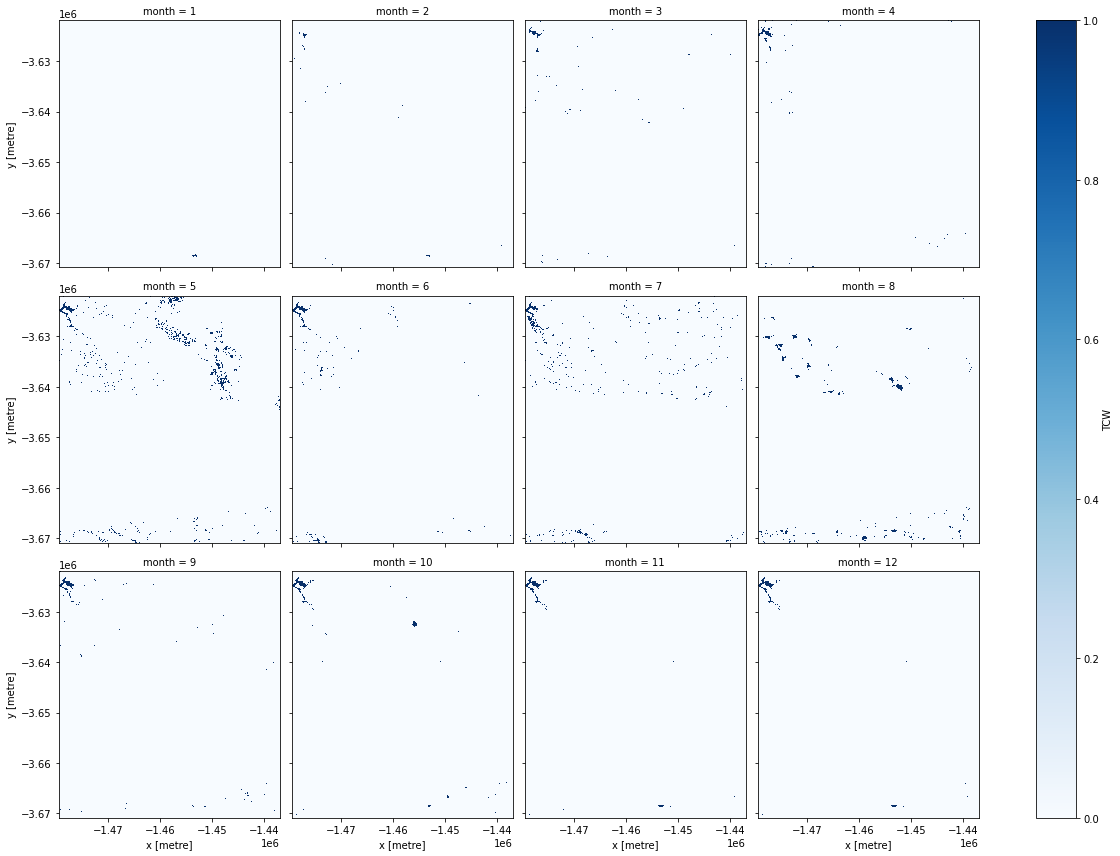

In [89]:
not_green.plot(col="month", cmap='Blues', col_wrap=4, size=4)
# fig = not_green.plot(col="month", cmap='Blues', col_wrap=4, size=4)
# fig
# plt.savefig('foo.png')

In [60]:
pwd

'/home/jovyan/dev/dea-notebooks/Gabrielle_dev/LCCS_wet_veg'

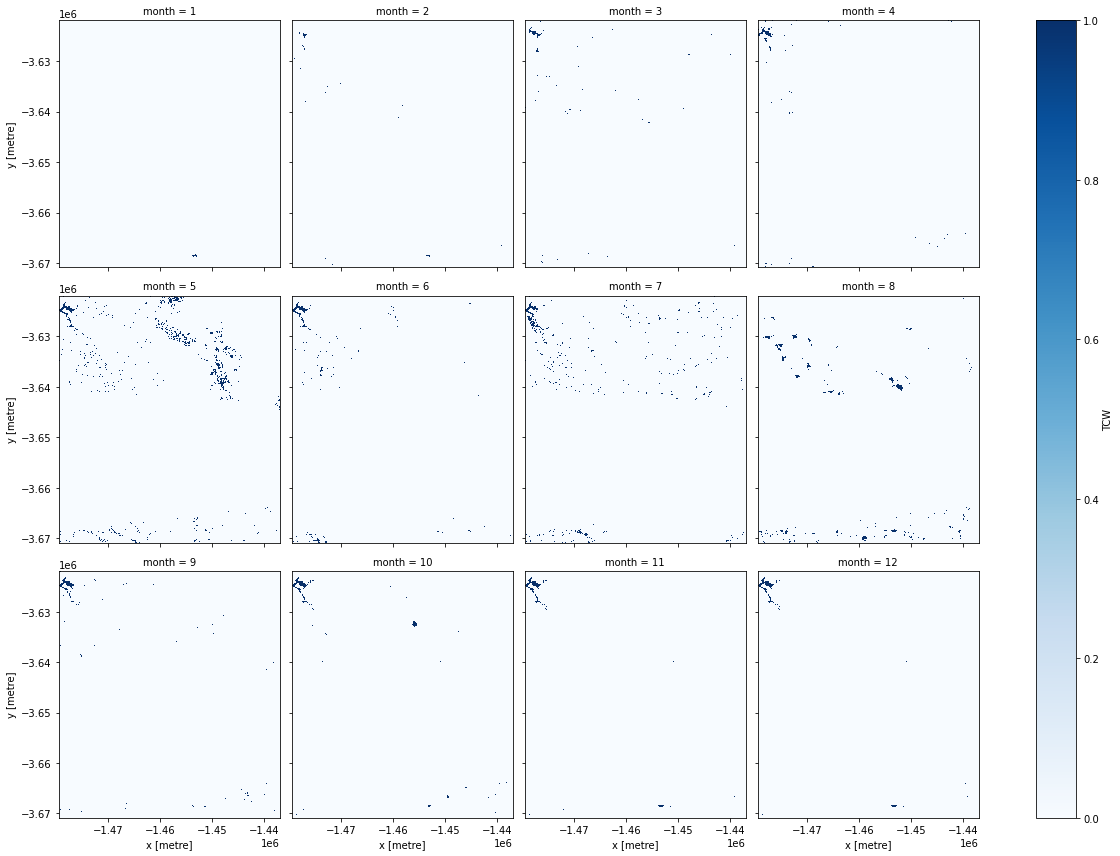

In [61]:
fig = not_green.plot(col="month", cmap='Blues', col_wrap=4, size=4)
fig
plt.savefig('foo.png')